# Pytorch starter - FasterRCNN Inference

This notebook will predict or count the object detected from the test data set.
> Teste data set will be the same 140 images used to train.

> The train data set was trained using the entire data set (264 bean images) due to the pseudo labling method deployed. Therefore, there is a different data set used to perform the inference or predictions analysis.

In [33]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and instaling the libraries

In [34]:
!pip install timm
!pip install pycocotools

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

!pip install albumentations==0.4.6

import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Directories input

In [35]:
DIR_INPUT = '/content/drive/MyDrive/UAS_Beans/Beans_StandCount/2022/SVREC/ByStep'

DIR_IMG = f'{DIR_INPUT}/k._TestingModel/6_13_22_SVREC_RGB_10m/Plots_Clip'

DIR_WEIGHTS = f'{DIR_INPUT}/h._TrainModel/BestModel_Train'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/FRCNN_1000ep_2bat_pseudo_final05_0.pth'

## Getting the image list

In [36]:
img_list = os.listdir(DIR_IMG)
img_list = [v for v in img_list if v.endswith('.png')]
print(img_list)
len(img_list)

['2202_4030_10m.png', '2202_4029_10m.png', '2202_4028_10m.png', '2202_4027_10m.png', '2202_4026_10m.png', '2202_3030_10m.png', '2202_3029_10m.png', '2202_3028_10m.png', '2202_3027_10m.png', '2202_3026_10m.png', '2201_4036_10m.png', '2201_4035_10m.png', '2201_4034_10m.png', '2201_4033_10m.png', '2201_4032_10m.png', '2201_4031_10m.png', '2201_3036_10m.png', '2201_3035_10m.png', '2201_3034_10m.png', '2201_3033_10m.png', '2201_3032_10m.png', '2201_3031_10m.png', '2201_3025_10m.png', '2201_3026_10m.png', '2201_3027_10m.png', '2201_3028_10m.png', '2201_3029_10m.png', '2201_3030_10m.png', '2201_4025_10m.png', '2201_4026_10m.png', '2201_4027_10m.png', '2201_4028_10m.png', '2201_4029_10m.png', '2201_4030_10m.png', '2202_3021_10m.png', '2202_3022_10m.png', '2202_3023_10m.png', '2202_3024_10m.png', '2202_3025_10m.png', '2202_4021_10m.png', '2202_4022_10m.png', '2202_4023_10m.png', '2202_4024_10m.png', '2202_4025_10m.png', '2202_4020_10m.png', '2202_4019_10m.png', '2202_4018_10m.png', '2202_4017_1

264

### Creating a list to save the predictions

In [37]:
test_df = pd.DataFrame(img_list, columns=['image_id'])
test_df['PredictionString'] = np.nan
test_df.head()


,image_id,PredictionString
0,2202_4030_10m.png,NaN
1,2202_4029_10m.png,NaN
2,2202_4028_10m.png,NaN
3,2202_4027_10m.png,NaN
4,2202_4026_10m.png,NaN


In [38]:
test_df.shape

(264, 2)

### Ploting a image example

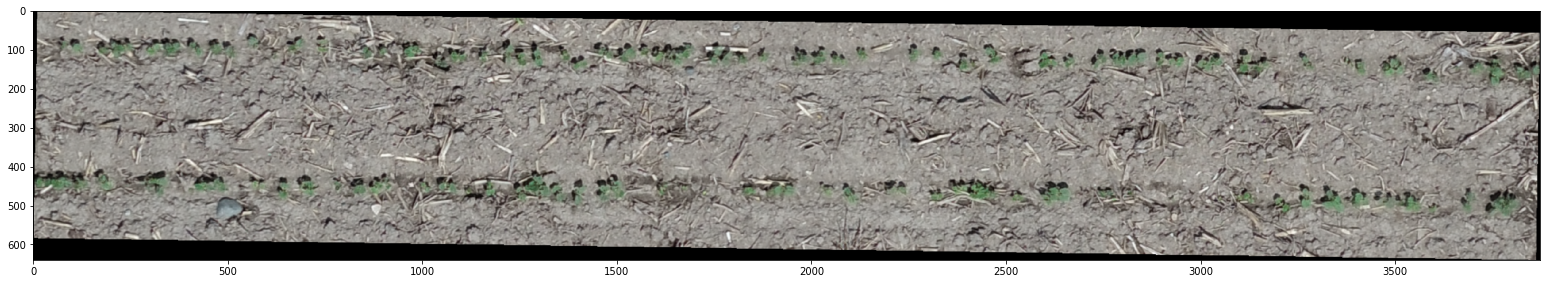

In [39]:
image = cv2.imread(f'{DIR_IMG}/2201_1021_10m.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (27,10))
plt.imshow(image)

## Dataset

In [40]:
class BeanTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [41]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])


## Model

In [42]:
# load a model; pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False,box_detections_per_img=180)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None,box_detections_per_img=180)

### Aux functions

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (bean) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [44]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = BeanTestDataset(test_df, DIR_IMG, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [45]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

## Predictions

In [46]:
detection_threshold = 0.1
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [47]:
results[0:2]

[{'image_id': '2202_4030_10m.png',
  'PredictionString': '0.9871 1575 475 32 53 0.9853 154 461 36 54 0.9843 461 461 29 53 0.9838 319 104 32 62 0.9820 3562 487 33 56 0.9807 1596 121 31 65 0.9778 1004 464 36 39 0.9772 1244 474 31 51 0.9772 1632 473 36 48 0.9770 2154 480 31 49 0.9741 2615 491 31 49 0.9726 878 460 29 48 0.9718 1079 476 32 46 0.9708 2423 498 39 47 0.9702 1400 479 36 50 0.9689 838 121 26 54 0.9673 2093 491 35 51 0.9671 3364 152 32 56 0.9661 1739 475 30 53 0.9653 1311 139 41 37 0.9650 735 465 27 43 0.9647 568 468 31 51 0.9640 691 118 34 43 0.9628 218 106 33 49 0.9619 3095 493 39 44 0.9619 1827 486 39 39 0.9593 1936 130 35 56 0.9592 2690 500 38 46 0.9576 1440 133 34 43 0.9568 266 457 35 47 0.9553 587 129 40 36 0.9539 1944 481 31 47 0.9531 1832 126 31 52 0.9518 3263 147 35 55 0.9512 2871 132 31 52 0.9499 3427 498 30 43 0.9484 3262 492 34 49 0.9478 3727 154 45 36 0.9472 2854 490 37 50 0.9461 2014 496 35 45 0.9439 318 461 35 42 0.9434 3434 158 37 55 0.9429 921 122 30 58 0.9376 18

### Saving

In [48]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()
#test_df.to_csv(f'{DIR_INPUT}/i._InferenceModel/Predictions/results_StandCount_raw.csv', index=False)

,image_id,PredictionString
0,2202_4030_10m.png,0.9871 1575 475 32 53 0.9853 154 461 36 54 0.9...
1,2202_4029_10m.png,0.9831 873 421 30 51 0.9816 1386 430 34 47 0.9...
2,2202_4028_10m.png,0.9842 971 402 32 54 0.9831 2729 422 30 43 0.9...
3,2202_4027_10m.png,0.9879 453 437 35 63 0.9871 2201 446 33 54 0.9...
4,2202_4026_10m.png,0.9872 1375 92 33 61 0.9869 1876 460 31 60 0.9...


### Displaying a prediction sample

In [49]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

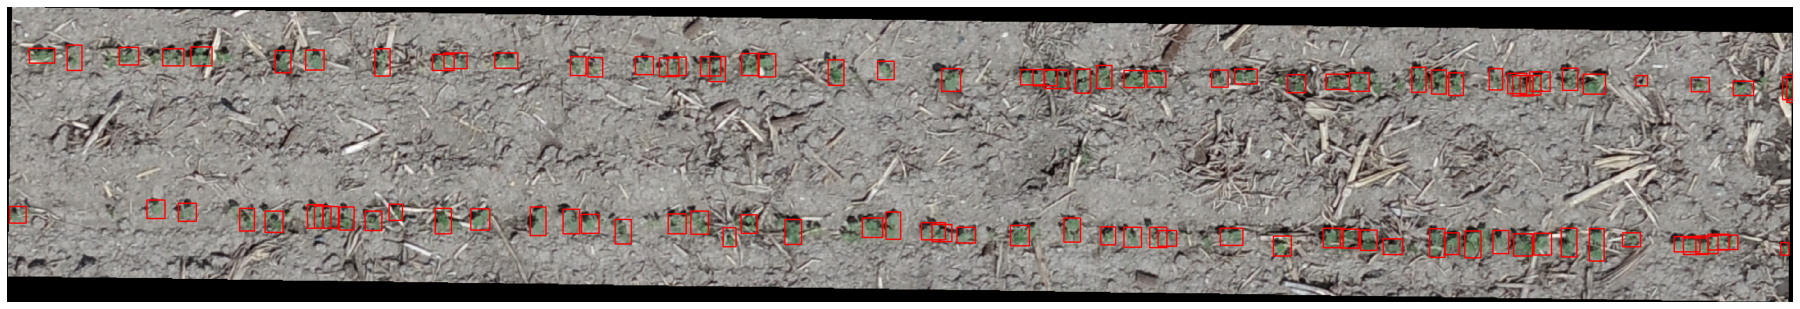

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(32, 12))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

## Predictions - Scores only

In [51]:
detection_threshold = 0.1
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        #boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        #boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        #boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        #boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': scores
        }

        
        results.append(result)


### Assigning a data frame

In [52]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,2202_4030_10m.png,"[0.98709583, 0.9852916, 0.9842858, 0.9838113, ..."
1,2202_4029_10m.png,"[0.983136, 0.9816, 0.97751516, 0.976352, 0.972..."
2,2202_4028_10m.png,"[0.98416317, 0.9830892, 0.98121005, 0.9786727,..."
3,2202_4027_10m.png,"[0.9879177, 0.987094, 0.97929037, 0.9757775, 0..."
4,2202_4026_10m.png,"[0.9871947, 0.9868608, 0.9825063, 0.9800489, 0..."


In [53]:
#if multiple columns and need join new df to existing
test_df2 = test_df.join(pd.DataFrame(test_df.pop('PredictionString').values.tolist(), index=test_df.index))
print(test_df2)

              image_id         0         1         2         3         4  \
0    2202_4030_10m.png  0.987096  0.985292  0.984286  0.983811  0.982037   
1    2202_4029_10m.png  0.983136  0.981600  0.977515  0.976352  0.972916   
2    2202_4028_10m.png  0.984163  0.983089  0.981210  0.978673  0.977824   
3    2202_4027_10m.png  0.987918  0.987094  0.979290  0.975778  0.970747   
4    2202_4026_10m.png  0.987195  0.986861  0.982506  0.980049  0.979351   
..                 ...       ...       ...       ...       ...       ...   
259  2202_2001_10m.png  0.983103  0.979610  0.979146  0.978643  0.975562   
260  2202_2002_10m.png  0.984133  0.983656  0.981009  0.980631  0.979568   
261  2202_2003_10m.png  0.985013  0.981765  0.979911  0.978960  0.974364   
262  2202_2004_10m.png  0.988533  0.987459  0.981475  0.980182  0.979973   
263  2202_2005_10m.png  0.981276  0.981158  0.978858  0.978341  0.977372   

            5         6         7         8  ...       110       111  112  \
0    0.980

### Counting the object detected

In [54]:
stand_count_list = []
shape = test_df2.shape

for i in range(len(test_df2.index)) :
    print("NaN in row ", i , " : " ,  test_df2.iloc[i].isnull().sum())
    count = ((shape[1]-1) - (test_df2.iloc[i].isnull().sum()))
    stand_count_list.append([count])
    
#new_df = pd.DataFrame(test_df2.iloc[i].isnull().sum(), columns=['stand_count'])
stand_count_list2 = np.array(stand_count_list)

NaN in row  0  :  30
NaN in row  1  :  28
NaN in row  2  :  24
NaN in row  3  :  15
NaN in row  4  :  28
NaN in row  5  :  0
NaN in row  6  :  24
NaN in row  7  :  27
NaN in row  8  :  56
NaN in row  9  :  22
NaN in row  10  :  52
NaN in row  11  :  15
NaN in row  12  :  29
NaN in row  13  :  16
NaN in row  14  :  24
NaN in row  15  :  28
NaN in row  16  :  14
NaN in row  17  :  14
NaN in row  18  :  17
NaN in row  19  :  13
NaN in row  20  :  26
NaN in row  21  :  13
NaN in row  22  :  27
NaN in row  23  :  23
NaN in row  24  :  15
NaN in row  25  :  18
NaN in row  26  :  20
NaN in row  27  :  22
NaN in row  28  :  27
NaN in row  29  :  43
NaN in row  30  :  33
NaN in row  31  :  33
NaN in row  32  :  23
NaN in row  33  :  14
NaN in row  34  :  25
NaN in row  35  :  24
NaN in row  36  :  14
NaN in row  37  :  12
NaN in row  38  :  1
NaN in row  39  :  35
NaN in row  40  :  28
NaN in row  41  :  13
NaN in row  42  :  13
NaN in row  43  :  18
NaN in row  44  :  21
NaN in row  45  :  35


In [55]:
# generating the Pandas dataframe
# from the Numpy array and specifying
# name of index and columns
panda_df = pd.DataFrame(data = stand_count_list2[0:, 0:],
                        index = [str(i + 1) 
                        for i in range(stand_count_list2.shape[0])],
                        columns = ['pred_count'])
  
# printing the dataframe

panda_df

,pred_count
1,90
2,92
3,96
4,105
5,92
...,...
260,103
261,99
262,104
263,112


### Merging the img name

In [56]:
stand_beans = pd.concat([test_df2['image_id'].reset_index(drop=True), panda_df['pred_count'].reset_index(drop=True)], axis=1)

stand_beans['image_id'] = stand_beans['image_id'].replace({'_10m.png':''}, regex=True)
print(stand_beans)


      image_id  pred_count
0    2202_4030          90
1    2202_4029          92
2    2202_4028          96
3    2202_4027         105
4    2202_4026          92
..         ...         ...
259  2202_2001         103
260  2202_2002          99
261  2202_2003         104
262  2202_2004         112
263  2202_2005          99

[264 rows x 2 columns]


### Merging to the annotations (GT)

In [57]:
bboxes_df = pd.read_csv('/content/drive/MyDrive/UAS_Beans/Beans_StandCount/2022/SVREC/ByStep/e._Resize_img_annot/Annot_beans_22_SVREC_7m__3.csv')
bboxes_df.head()

,image_id,width,height,bbox,source
0,2202_3008_7m,3872,640,"[544.9039548022599, 135.4396423248882, 29.8305...",bean
1,2202_3008_7m,3872,640,"[579.7062146892656, 124.9478390461997, 27.8418...",bean
2,2202_3008_7m,3872,640,"[609.5367231638418, 141.1624441132638, 11.9322...",bean
3,2202_3008_7m,3872,640,"[648.316384180791, 123.99403874813711, 30.8248...",bean
4,2202_3008_7m,3872,640,"[688.090395480226, 146.88524590163934, 29.8305...",bean


In [58]:
# get number of bboxes for each image_id
df_folds = bboxes_df.groupby('image_id', as_index=False).count()
df_folds
df_folds_sel = df_folds[['image_id', 'width']]
df_folds_sel.columns=['image_id', 'boxes_gt']
df_folds_sel['image_id'] = df_folds_sel['image_id'].replace({'_7m':''}, regex=True)

df_folds_sel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image_id,boxes_gt
0,2201_1001,114
1,2201_1002,119
2,2201_1003,128
3,2201_1004,128
4,2201_1005,131
...,...,...
135,2202_3004,120
136,2202_3005,124
137,2202_3006,126
138,2202_3007,115


In [59]:
results = pd.merge(stand_beans, df_folds_sel)
results

,image_id,pred_count,boxes_gt
0,2202_3008,85,109
1,2202_3007,90,115
2,2202_3006,99,126
3,2202_3001,113,134
4,2202_3002,102,126
...,...,...,...
135,2202_2001,103,131
136,2202_2002,99,128
137,2202_2003,104,130
138,2202_2004,112,145


### Saving the results

In [60]:
results.to_csv(f'{DIR_INPUT}/k._TestingModel/6_13_22_SVREC_RGB_10m/Inference/results_6_13_SVREC_RGB_10m_TH01.csv', index=False)